# importing necesary libraries

In [1]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Abstract methods
here i create abstract methods for solver, and functions

In [2]:
class Solver(ABC):
    """A solver. It may be initialized with some hyperparameters."""

    @abstractmethod
    def get_parameters(self):
        """Returns a dictionary of hyperparameters"""
        pass

    @abstractmethod
    def solve(self, problem, x0, *args, **kwargs):
        """
        A method that solves the given problem for given initial solution.
        It may accept or require additional parameters.
        Returns the solution and may return additional info.
        """
        pass


class Function(ABC):
    """A function. It may be initialized with some parameters."""

    @abstractmethod
    def __call__(self, x, *args, **kwargs):
        """
        A method that returns the value of the function at given point.
        It may accept or require additional parameters.
        """
        pass

    @abstractmethod
    def gradient(self, x, *args, **kwargs):
        """
        A method that returns the gradient of the function at given point.
        It may accept or require additional parameters.
        """
        pass

the purpouse of class AnyFunction is to just hold both the normal function and its gradient in one callable obcect

In [3]:
class AnyFunction(Function):
    def __init__(self, equation, gradient):
        self.equation = equation
        self.gradient_func = gradient

    def __call__(self, x, *args, **kwargs):
        return self.equation(x)

    def gradient(self, x, *args, **kwargs):
        return self.gradient_func(x)


# Gradient Decent solver
in the code below i implemtented a simple gradient decent solver that for every point that for a number of iterations it is currently in calculates the gradient of the function and then substracts the gradient*stepsize from the current position

I also experimented with two other functionalities:

1. early_stop: when it is active the solver will stop looking for a minimum if the length af the gradient vector is shorter then early_stop value, it is good if the function changes somewhat rapidly in everywhere, rather then in minimum, but very bad when the function has areas where it is still, doesn't change too much, because when the solver gets started in such a point then the solver will immidietly stop solving for minimums


2. get_angry: the aim of this functionality was to be able to get out of the very still regions, in such a way that it will inrease step_size untill the algorythm will want to make a step of lenght bigger then calm_down_treshold, then it returns to the oryginal value of step_size. argument patience is for determining how long the algorythm will wait (how many iterations) untill it starts getting angry with inaction.
If get_angry is set to true, every time the algorythm gets angry it saves the current point it is currently in and then starts gaining momentum (increasing step_size) untill it makes a move bigger then of lenght one. It doesn't make the move if the step it is going to make is 2 times longer then calm_down_treshold

I also added some other features to get_anrgy functionality like:
- random_spin: after algorythm has saved at least 5 (the value can be changed) potencial minimums within some approximation it will start applying random spin to its movement to have a possibility of 'jumping' from a local minimum to a global one


In [41]:
class GradientDescentSolver(Solver):
    def __init__(self, step_size=0.1, max_iter=1000, early_stop=None, get_angry=False, calm_down_treshold=None, patience=None, anger_threshold=None, spin_treshold=None):
        self.step_size = step_size
        self.max_iter = max_iter
        self.stop = early_stop

        self.get_angry = get_angry
        if get_angry:
            self.last_improvements = []
            self.patience = patience
            self.calm_down_treshold = calm_down_treshold
            self.saved_potencial_minimums = []
            self.anger_threshold = anger_threshold
            self.spin_treshold = spin_treshold

    def set_step_size(self, new_step_size):
        self.step_size = new_step_size
        print(f"changed step size to {new_step_size}")

    def get_parameters(self):
        return {"step_size": self.step_size, "max_iter": self.max_iter, "early_stop": self.stop, "get_angry": self.get_angry}

    def solve(self, function, x0):
        x = x0
        init_step_size = self.step_size

        gaining_momentum = False

        apply_spin = False

        for i in range(self.max_iter):
            grad = function.gradient(x)

            if self.stop is not None and np.linalg.norm(grad) < self.stop:
                break

            print(f"iter {i}, x = {x}, f(x) = {function(x)}, grad = {grad}, grad_norm = {np.linalg.norm(grad)}, step_size = {self.step_size}, apply_spin = {apply_spin}")

            x_new = x - (self.step_size * grad)
            step_lenght = (np.linalg.norm(np.array(self.step_size * grad)))

            if self.get_angry:
                make_move = True
                if gaining_momentum:
                    if step_lenght > self.calm_down_treshold:
                        self.step_size = init_step_size
                        gaining_momentum = False
                        if step_lenght > float(self.calm_down_treshold * 2):
                            make_move = False
                    else:
                        self.step_size *= 1.1

                if len(self.last_improvements) >= self.patience and max(self.last_improvements) < self.anger_threshold and not gaining_momentum:
                    print(f"saving potencial minimum {x_new}")
                    self.saved_potencial_minimums.append(x_new)
                    gaining_momentum = True
                    self.last_improvements = []

                if len(self.last_improvements) >= self.patience:
                    self.last_improvements.pop(0)

                if make_move is True:
                    if apply_spin and gaining_momentum:
                        theta = np.random.uniform(0, 2*np.pi)  # Random angle in [0, 2pi]
                        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                                    [np.sin(theta),  np.cos(theta)]])
                        x = np.dot(rotation_matrix, x_new)
                    else:
                        x = x_new

                self.last_improvements.append(abs(function(x) - function(x_new)))
                simmilar_minimums = 0

                if len(self.saved_potencial_minimums) > 4:
                    temp_saved_potencial_minimums = np.array(self.saved_potencial_minimums)
                    for i in range(len(temp_saved_potencial_minimums)):
                        if apply_spin:
                            break
                        for j in range(i+1, len(temp_saved_potencial_minimums)):
                            if np.allclose(temp_saved_potencial_minimums[i], temp_saved_potencial_minimums[j], atol=self.spin_treshold):
                                simmilar_minimums += 1
                            if simmilar_minimums > 5:
                                apply_spin = True
                                break
            else:
                x = x_new

        if self.get_angry:
            print(len(self.saved_potencial_minimums))
            best_val = None
            for minimum in self.saved_potencial_minimums:
                if best_val is None or function(minimum) < best_val:
                    best_val = function(minimum)
                    x = minimum

        return x

# Difine functions
- here i define functions that were given in excersize file, make an object for each of them to be able to hold both the normal functions and their gradients in one object
- then i initialize solver object with some arguments, for the first function (1D) it is best to not youse get_angry option as it increases the step_size to infinity, i chose to not hard code any limitations on how big it can get, to not make the solution too complex (also it is just a mode i experimented with, not the original task)
- this solver can solve both functions without changing anything in the solver

In [42]:
def function1(x):
    return 2 * x**2 + 3 * x - 1

def gradient1(x):
    return 4 * x + 3

def function2(x):
    return 1 - 0.6 * np.exp(-x[0]**2 - x[1]**2) - 0.4 * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2)

def gradient2(x):
    return np.array(
        [
            1.2 * x[0] * np.exp(-x[0]**2 - x[1]**2) + 0.8 * (x[0] + 1.75) * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2),
            1.2 * x[1] * np.exp(-x[0]**2 - x[1]**2) + 0.8 * (x[1] - 1) * np.exp(-(x[0] + 1.75)**2 - (x[1] - 1)**2)
        ])

# Initialize an AnyFunction object
f = AnyFunction(function1, gradient1)

g = AnyFunction(function2, gradient2)

solver = GradientDescentSolver(step_size=0.1, max_iter=10000, get_angry=True, calm_down_treshold=1, patience=50, anger_threshold=1e-5, spin_treshold=1e-4)

solver.solve(g, [3, 3])

iter 0, x = [3, 3], f(x) = 0.9999999908608478, grad = [5.48389892e-08 5.48325848e-08], grad_norm = 7.754951377305036e-08, step_size = 0.1, apply_spin = False
[3, 3]
iter 1, x = [2.99999999 2.99999999], f(x) = 0.9999999908608471, grad = [5.48389927e-08 5.48325883e-08], grad_norm = 7.754951873438089e-08, step_size = 0.1, apply_spin = False
[2.99999999 2.99999999]
iter 2, x = [2.99999999 2.99999999], f(x) = 0.9999999908608466, grad = [5.48389962e-08 5.48325918e-08], grad_norm = 7.754952369571199e-08, step_size = 0.1, apply_spin = False
[2.99999999 2.99999999]
iter 3, x = [2.99999998 2.99999998], f(x) = 0.9999999908608459, grad = [5.48389997e-08 5.48325953e-08], grad_norm = 7.754952865704396e-08, step_size = 0.1, apply_spin = False
[2.99999998 2.99999998]
iter 4, x = [2.99999998 2.99999998], f(x) = 0.9999999908608453, grad = [5.48390032e-08 5.48325988e-08], grad_norm = 7.75495336183765e-08, step_size = 0.1, apply_spin = False
[2.99999998 2.99999998]
iter 5, x = [2.99999997 2.99999997], f(x

array([-0.02210977,  0.01225914])

# Functions visualization
- here i plot using matplotlib functions that the solver will later solve (find their minimums)
- the idea for get_angry functionality was based on the plot of the 2D function, other then two regions where it has a global and a local minimum its value is very close to 1, the gradient is close to 0, so it is hard for the solver to get out of this still region

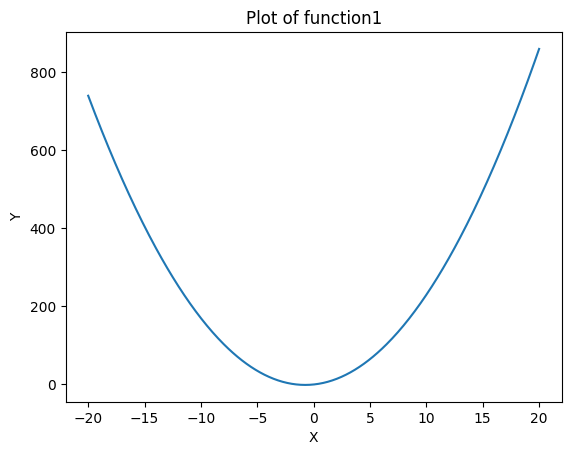

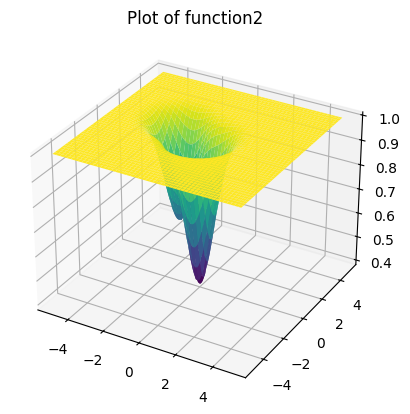

In [6]:
# Generate x values
x = np.linspace(-20, 20, 400)

# Compute y values
y = function1(x)

# Create the plot
plt.plot(x, y)

# Optionally set the title and labels
plt.title('Plot of function1')
plt.xlabel('X')
plt.ylabel('Y')

# Display the plot
plt.show()

size = 5

x = np.linspace(-size, size, 200)
y = np.linspace(-size, size, 200)

X, Y = np.meshgrid(x, y)
Z = function2([X, Y])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.title('Plot of function2')

plt.show()

# generate 100 random starting points for each function

In [7]:
random_points_f = np.random.uniform(-10, 10, size=(100, 1))
random_points_g = np.random.uniform(-size, size, size=(100, 2))

## Display the generated points

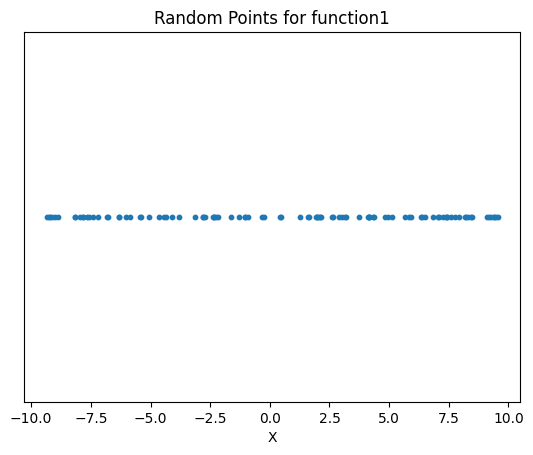

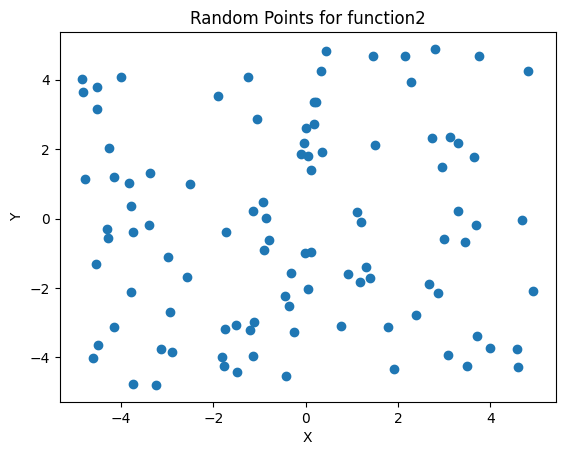

In [8]:
# Create a scatter plot of the points with smaller dots
plt.scatter(random_points_f, np.zeros_like(random_points_f), s=10)

# Hide the y-axis
plt.gca().axes.get_yaxis().set_visible(False)


# Optionally set the title and labels
plt.title('Random Points for function1')
plt.xlabel('X')

# Display the plot
plt.show()



# Split the array into x and y coordinates
x_coords, y_coords = random_points_g[:, 0], random_points_g[:, 1]

# Create a scatter plot of the points
plt.scatter(x_coords, y_coords)

# Optionally set the title and labels
plt.title('Random Points for function2')
plt.xlabel('X')
plt.ylabel('Y')

# Display the plot
plt.show()



In [9]:
def choose_best_step_size(function, step_sizes, random_points, solver, goal):
    X = []
    Y = []
    for step_size in step_sizes:
        per_step_size_performance = []
        solver.set_step_size(step_size)
        for point in random_points:
            x = solver.solve(function, point)

            difference = abs(function(x) - function(goal))

            per_step_size_performance.append(mul_diff)
        per_step_size_performance = np.array(per_step_size_performance)
        X.append(step_size)
        Y.append(per_step_size_performance)
    return X, Y


# Generate 100 random stepsizes

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 random step sizes between 0.01 and 1
step_sizes = np.random.uniform(0.001, 0.1, 100)

goal = [-0.0219421, 0.01254356]

X, Y = choose_best_step_size(g, step_sizes, random_points_g, solver, goal)
X = np.array(X)
Y = np.array(Y)

# using enetplot.ipynb write a function that will plot the performance of different step sizes
plt.style.use('_mpl-gallery')

# plot:
fig, ax = plt.subplots()

ax.eventplot(D, orientation="vertical", lineoffsets=x, linewidth=0.25)

# x_min = X.min()
# x_max = X.max()
# y_min = None
# y_max = None
# for column in Y:
#     y_pos_min = column.min()
#     y_pos_max = column.max()

#     if y_min is None or y_pos_min < y_min:
#         y_min = y_pos_min

#     if y_max is None or y_pos_max > y_max:
#         y_max = y_pos_max

# ax.set(xlim=(0, 8), xticks=np.arange(1, 9),
#        ylim=(0, 8), yticks=np.arange(1, 9))

plt.show()


changed step size to 0.073468197905074
iter 0, x = [1.49055821 2.1067884 ], f(x) = 0.9992283272466673, grad = [0.00231176 0.00324504], grad_norm = 0.003984281611875939, step_size = 0.073468197905074, apply_spin = False
iter 1, x = [1.49038837 2.10654999], f(x) = 0.9992271601601915, grad = [0.00231499 0.00324958], grad_norm = 0.003989855187917826, step_size = 0.073468197905074, apply_spin = False
iter 2, x = [1.49021829 2.10631125], f(x) = 0.9992259898051415, grad = [0.00231824 0.00325413], grad_norm = 0.0039954436366548265, step_size = 0.073468197905074, apply_spin = False
iter 3, x = [1.49004797 2.10607218], f(x) = 0.9992248161682036, grad = [0.00232149 0.00325869], grad_norm = 0.004001047016489751, step_size = 0.073468197905074, apply_spin = False
iter 4, x = [1.48987741 2.10583277], f(x) = 0.9992236392359932, grad = [0.00232475 0.00326327], grad_norm = 0.0040066653861280015, step_size = 0.073468197905074, apply_spin = False
iter 5, x = [1.48970662 2.10559302], f(x) = 0.9992224589950

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:




# f_xmin, f_vals = solver.solve(f, 0)
g_xmin, g_vals = solver.solve(g, [-5, 5])

print("found minimum for f at x = ", f_xmin)

print("found minimum for g at x = ", g_xmin)

print(f(f_xmin))
print(g(g_xmin))

NameError: name 'f_xmin' is not defined